In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Setting

In [2]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 랜덤 시드 고정
import random
np.random.seed(1234)
random.seed(1234)

In [4]:
# 데이터셋 불러기기
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [5]:
# warning 시시
import warnings
warnings.filterwarnings("ignore")

### File descriptions
- **train.csv** - the training set
- **test.csv** - the test set
- **data_description.txt** - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- **sample_submission.csv** - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

## Baseline

In [6]:
# train_df 확인
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# 각 column의 데이터 타입 확인
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [8]:
# MSZoing의 value_counts 확인 (각 값의 개수)
train_df["MSZoning"].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [9]:
# train_df에서의 결측치 개수 확인
missing_counts = train_df.isnull().sum()
# 결측치가 있는 column만 출력(내림차순)
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [10]:
# test_df 결측치 확인 (train_df와 동일)
missing_counts = test_df.isnull().sum()
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64


In [11]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

train_categories = train_df.columns[train_df.dtypes=="object"]
print(f"train_categories: {train_categories}")

test_categories = test_df.columns[test_df.dtypes=="object"]
print(f"test_categories: {test_categories}")

train_categories: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
test_categories: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundatio

In [12]:
# dtypes가 object인 모든 column을 대상으로 라벨 인코딩 수행 (train_df)
for cat in train_categories:
    le = LabelEncoder()
    print(cat)

    train_df[cat] = train_df[cat].fillna("missing")
    le = le.fit(train_df[cat])
    train_df[cat] = le.transform(train_df[cat])
    train_df[cat] = train_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [13]:
# dtypes가 object인 모든 column을 대상으로 라벨 인코딩 수행(test_df)
for cat in test_categories:
    le = LabelEncoder()
    print(cat)

    test_df[cat] = test_df[cat].fillna("missing")
    le = le.fit(test_df[cat])
    test_df[cat] = le.transform(test_df[cat])
    test_df[cat] = test_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [14]:
# KFold
from sklearn.model_selection import KFold
folds=3
kf = KFold(n_splits=folds)

In [15]:
# LightGBM 세팅
import lightgbm as lgb
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

In [16]:
# 필요 없는 변수와 타겟 변수 제거
train_X = train_df.drop(["SalePrice", "Id"], axis=1)
# 타겟변수
train_Y = train_df["SalePrice"]

In [17]:
# Loss Function (MSE)
from sklearn.metrics import mean_squared_error

# Early stopping
from lightgbm import early_stopping

In [18]:
# Model Baseline
models = []
rmses = [] # root(MSE)
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(
        params=lgbm_params,
        train_set=lgb_train,
        valid_sets=[lgb_eval],
        num_boost_round=1000,
        callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
    )
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

In [19]:
# 평균 RMSE (낮을 수록 좋음)
sum(rmses)/len(rmses)

0.13608152733482728

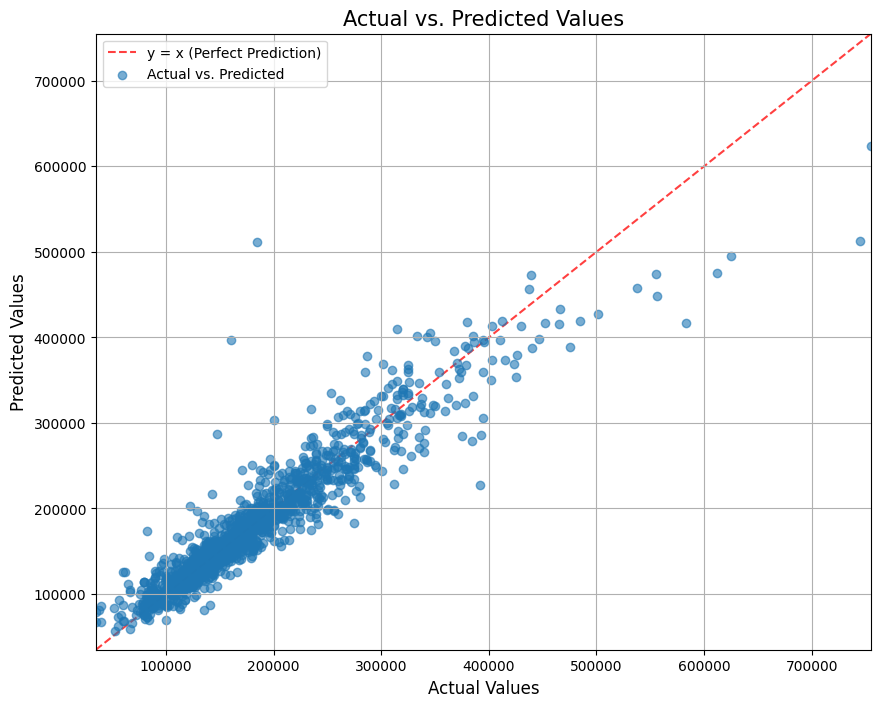

In [20]:
# 실제 값과 예측값 그래프 그리기
# dataframe 생성
actual_pred_df = pd.DataFrame({
    'actual': train_Y,
    'pred': oof
})

fig, ax = plt.subplots(figsize=(10, 8))

# Draw the y=x reference line
# x축과 y축의 길이가 같도록 설정
lims = [
    np.min([actual_pred_df['actual'].min(), actual_pred_df['pred'].min()]),
    np.max([actual_pred_df['actual'].max(), actual_pred_df['pred'].max()]),
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='y = x (Perfect Prediction)')

# scatter plot
ax.scatter(actual_pred_df['actual'], actual_pred_df['pred'], alpha=0.6, label='Actual vs. Predicted')

# 라벨과 제목
ax.set_xlabel('Actual Values', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.set_title('Actual vs. Predicted Values', fontsize=15)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.legend()
plt.grid(True)
plt.show()

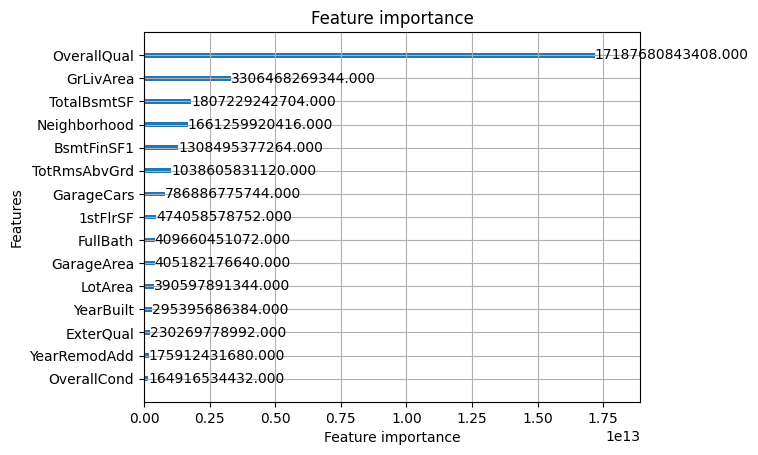

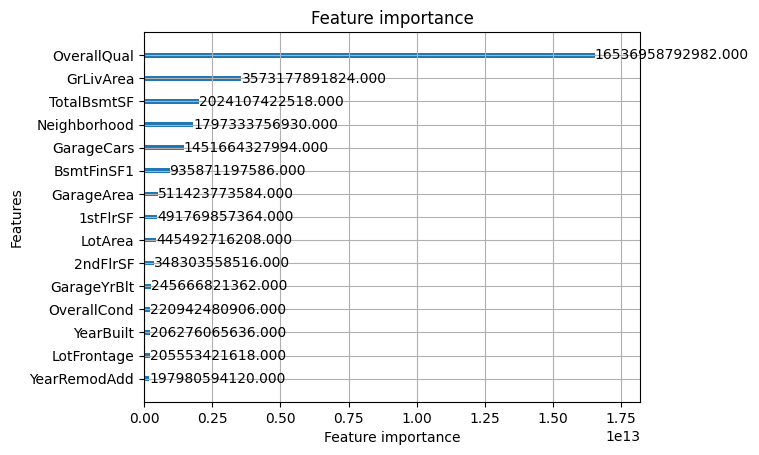

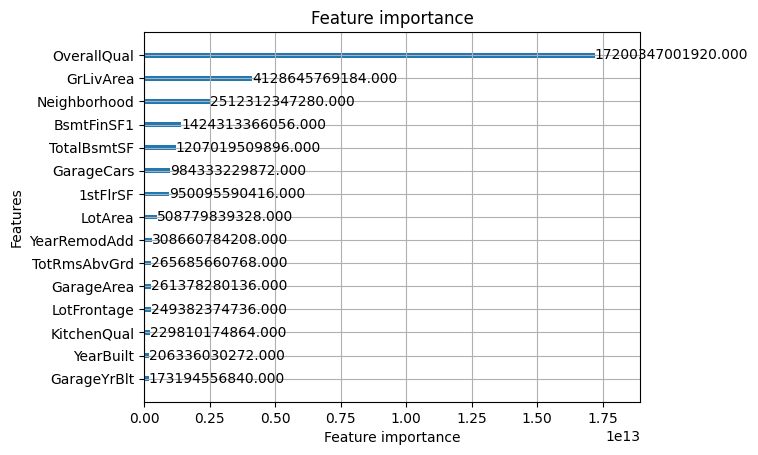

In [21]:
# importance 확인
for model in models:
    lgb.plot_importance(model,importance_type="gain", max_num_features=15)

### 상위권 importance
- **OverallQual** : Overall material and finish quality (재료와 마감 품질)
- **GrLivArea** : Above grade (ground) living area square feet (지상 거주 공간 square feet)
- **Neighborhood** : Physical locations within Ames city limits (물리적 위치)
- **TotalBsmtSF** : Total square feet of basement area (지하실 면적)
- **BsmtFinSF1** : Type 1 finished square feet

## Preprocessing

### Preprocessing1: Log the target variable

-> target variable에 log

In [22]:
# Distribution of SalePrice
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

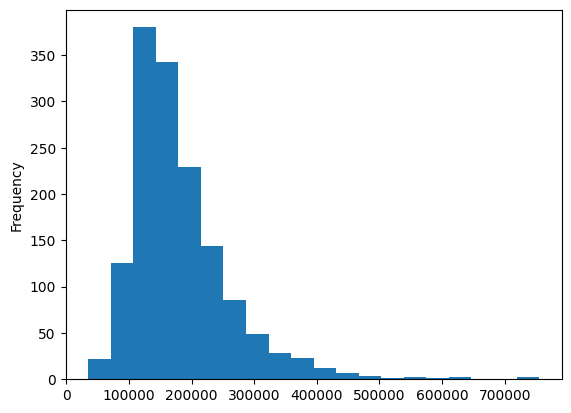

In [23]:
# SalePrice 히스토그램
train_df["SalePrice"].plot.hist(bins=20)

# mean     180921.195890

In [24]:
# Log the target variable
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<Axes: ylabel='Frequency'>

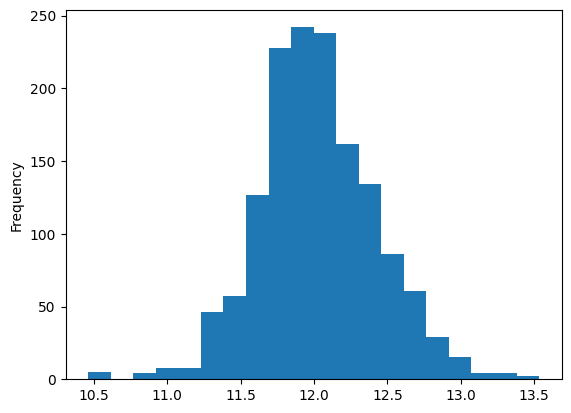

In [25]:
np.log(train_df['SalePrice']).plot.hist(bins=20)

- 로그를 취하니 정규분포에 비슷한(?) 형태를 보임   
-> 회귀 모델은 타겟 값이 정규 분포의 형태일 때 더 좋은 성능을 냄
- 로그를 취함으로써 이상치에 대한 영향력이 줄어듦

In [26]:
# 데이터셋에 log(SalePrice) 적용
pd.options.mode.chained_assignment = None
train_df["SalePrice_log"] = np.log(train_df["SalePrice"])
train_X = train_df.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df["SalePrice_log"]

In [27]:
# Model
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(
        params=lgbm_params,
        train_set=lgb_train,
        valid_sets=[lgb_eval],
        num_boost_round=1000,
        callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
    )
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

In [28]:
# Avergue RMSE
print("before : 0.13608152733482728")
print(f"log : {sum(rmses)/len(rmses)}")

before : 0.13608152733482728
log : 0.13172289351995295


### Preprocessing2: Transform explanatory variables with many missing values

In [29]:
# "PoolQC", "MiscFeature", "Alley"는 결측치가 90%가 넘는다. 
# 이는 , 모델 성능의 저하로 이어지므로, 원래는 ‘Ex’, ‘Gd’, ‘Fa’ 등 시설의 등급/명칭이 들어 있으나, 
# 시설이 있으면 1, 없으면(결측) 0으로 단순화한다.
# 추후, 시설 등급과 SalePrice의 correlation을 확인해 보는 것도 괜찮을 듯

tmp_train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
tmp_test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

print(tmp_train_df.PoolQC.value_counts(), f"\nNaN value: {tmp_train_df.PoolQC.isnull().sum()}\n")
print(tmp_train_df.MiscFeature.value_counts(), f"\nNaN value: {tmp_train_df.MiscFeature.isnull().sum()}\n")
print(tmp_train_df.Alley.value_counts(), f"\nNaN value: {tmp_train_df.Alley.isnull().sum()}\n")
print("\n\n")
print(tmp_test_df.PoolQC.value_counts(), f"\nNaN value: {tmp_test_df.PoolQC.isnull().sum()}\n")
print(tmp_test_df.MiscFeature.value_counts(), f"\nNaN value: {tmp_test_df.MiscFeature.isnull().sum()}\n")
print(tmp_test_df.Alley.value_counts(), f"\nNaN value: {tmp_test_df.Alley.isnull().sum()}\n")

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64 
NaN value: 1453

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64 
NaN value: 1406

Alley
Grvl    50
Pave    41
Name: count, dtype: int64 
NaN value: 1369




PoolQC
Ex    2
Gd    1
Name: count, dtype: int64 
NaN value: 1456

MiscFeature
Shed    46
Gar2     3
Othr     2
Name: count, dtype: int64 
NaN value: 1408

Alley
Grvl    70
Pave    37
Name: count, dtype: int64 
NaN value: 1352



In [30]:
# 값 변환
cols = ["PoolQC", "MiscFeature", "Alley"]

for d in [tmp_train_df, tmp_test_df]:
    d['hasHighFacility'] = d[cols].notnull().astype(int).sum(axis=1)

train_df['hasHighFacility'] = tmp_train_df['hasHighFacility'].values
test_df['hasHighFacility']  = tmp_test_df['hasHighFacility'].values

train_df.drop(cols, axis=1, inplace=True)
test_df.drop(cols, axis=1, inplace=True)

print(train_df['hasHighFacility'].value_counts())
print(test_df['hasHighFacility'].value_counts())

# 0 -> 고급 주택 설비 없음
# 1 -> 고급 주택 설비 1개
# 2 -> 고급 주택 설비 2개

hasHighFacility
0    1313
1     142
2       5
Name: count, dtype: int64
hasHighFacility
0    1302
1     153
2       4
Name: count, dtype: int64


### Preprocessing3: Outlier

In [31]:
# train_df의 데이터 형태 확인
train_df.describe().T # T -> Transpose

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.000000,365.750000,730.500000,1095.250000,1460.000000
MSSubClass,1460.0,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,1201.0,70.049958,24.284752,21.000000,59.000000,69.000000,80.000000,313.000000
LotArea,1460.0,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
OverallQual,1460.0,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1460.0,5.575342,1.112799,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1460.0,1971.267808,30.202904,1872.000000,1954.000000,1973.000000,2000.000000,2010.000000
YearRemodAdd,1460.0,1984.865753,20.645407,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1452.0,103.685262,181.066207,0.000000,0.000000,0.000000,166.000000,1600.000000
BsmtFinSF1,1460.0,443.639726,456.098091,0.000000,0.000000,383.500000,712.250000,5644.000000


In [32]:
# 숫자형 데이터 feature 발췌
train_df_num = train_df.select_dtypes(include=[np.number])
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'SalePrice_log',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'hasHighFacility']

In [33]:
# 대부분의 값이 0인 features
train_df_num_rs = train_df_num[num_features]
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0: # 75
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344
hasHighFacility 1313


In [34]:
# 이상치 확인
for col in num_features:
    tmp_df = train_df_num_rs[
        (train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std() * 3) | 
        (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std() * 3)
    ]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
SalePrice_log 12
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22
hasHighFacility 5


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,hasHighFacility
1298,1299,60,3,313.0,63887,1,2,0,0,0,...,480,4,0,1,2008,6,5,160000,11.982929,1


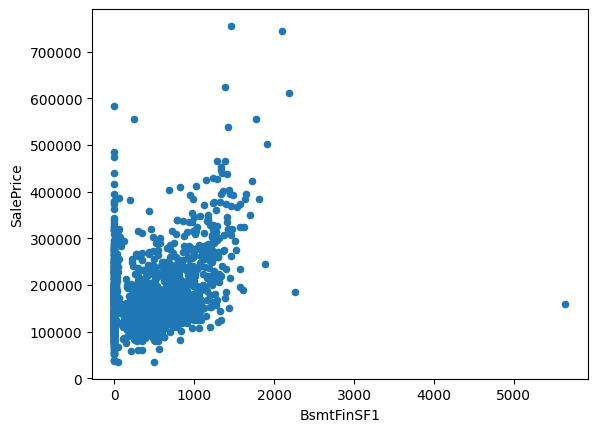

In [35]:
# scatter을 통해 SalePrice와 이상치가 발견된 feature를 확인
train_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")
train_df[train_df["BsmtFinSF1"] > 5000] 
# 그래프를 확인 한 결과 5000이 넘는 이상치가 하나 발견됨

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,hasHighFacility
1298,1299,60,3,313.0,63887,1,2,0,0,0,...,480,4,0,1,2008,6,5,160000,11.982929,1


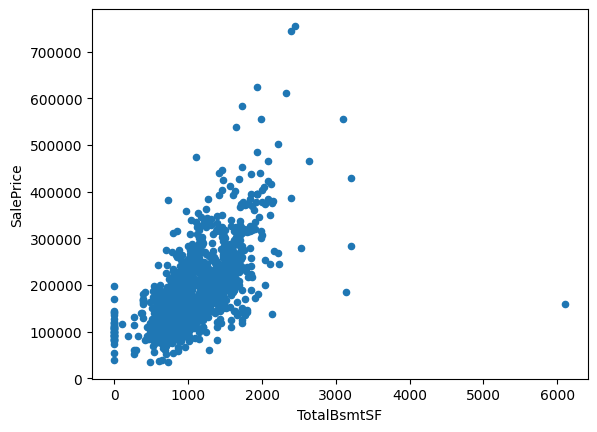

In [36]:
train_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")
train_df[train_df["TotalBsmtSF"] > 6000]
# 6000이 넘는 이상치 발견 (plot에서 확인 가능)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,hasHighFacility
1298,1299,60,3,313.0,63887,1,2,0,0,0,...,480,4,0,1,2008,6,5,160000,11.982929,1


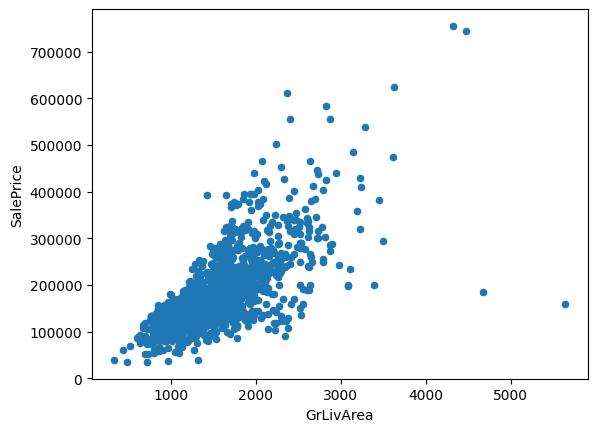

In [37]:
train_df.plot.scatter(x="GrLivArea", y="SalePrice")
train_df[train_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,hasHighFacility
1298,1299,60,3,313.0,63887,1,2,0,0,0,...,480,4,0,1,2008,6,5,160000,11.982929,1


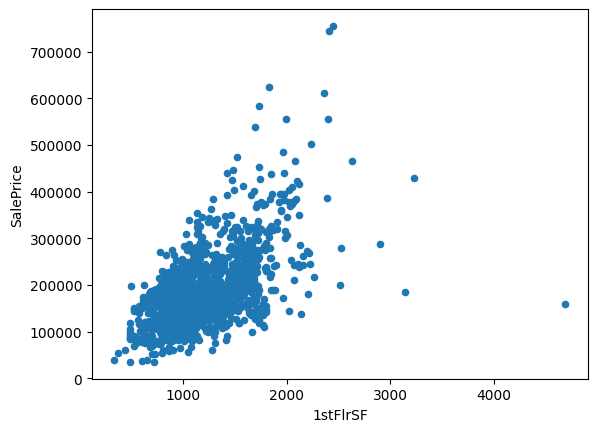

In [38]:
train_df.plot.scatter(x="1stFlrSF", y="SalePrice")
train_df[train_df["1stFlrSF"] > 4000]

In [39]:
# 이상치 제거 (위 plot에서 확인한 row 제거)
train_df = train_df[(train_df['BsmtFinSF1'] < 2000)]
train_df = train_df[(train_df['TotalBsmtSF'] < 3000)]
train_df = train_df[(train_df['GrLivArea'] < 4500)]
train_df = train_df[(train_df['1stFlrSF'] < 2500)]
train_df = train_df[(train_df['LotArea'] < 100000)]

In [40]:
# train, test 데이터 분할
train_df["SalePrice_log"] = np.log(train_df["SalePrice"])
train_X = train_df.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df["SalePrice_log"]
test_X = test_df.drop(["Id"], axis=1)

In [41]:
# Model
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(
        params=lgbm_params,
        train_set=lgb_train,
        valid_sets=[lgb_eval],
        num_boost_round=1000,
        callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
    )
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

      MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
487           20        3         70.0    12243      1        0           3   
488          190        3         60.0    10800      1        3           3   
489          180        4         21.0     1526      1        3           3   
490          160        4          NaN     2665      1        3           3   
491           50        3         79.0     9490      1        3           3   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60        3         62.0     7917      1        3           3   
1456          20        3         85.0    13175      1        3           3   
1457          70        3         66.0     9042      1        3           3   
1458          20        3         68.0     9717      1        3           3   
1459          20        3         75.0     9937      1        3           3   

     Utilities LotConfig LandSlope  ... 3SsnPorch S

In [42]:
print("before preprocessing : 0.13608152733482728")
print("log SalePrice : 0.13172289351995295")
print(f"drop outliers : {sum(rmses)/len(rmses)}")

before preprocessing : 0.13608152733482728
log SalePrice : 0.13172289351995295
drop outliers : 0.1294706948265821
